In [1]:
import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import matplotlib.pyplot as plt
import gym_sin
from gym import spaces

from utilities.arguments import get_args
from learner.posterior_multi_task import PosteriorMTAgent
from inference.inference_network import InferenceNetwork
from ppo_a2c.envs import make_vec_envs_multi_task, get_vec_envs_multi_task
from task.GuassianTaskGenerator import GaussianTaskGenerator
from utilities.folder_management import handle_folder_creation


ModuleNotFoundError: No module named 'learner.posterior_multi_task'

In [429]:
def get_sin_task_sequence(alpha, n_restarts, num_test_processes, std=0.00000001):
    kernel = C(1.0, (1e-8, 1e8)) * RBF(1, (1e-8, 1e8))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=False,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    f = 0.1
    offset = 0
    a = 0.9

    init_prior_test = [torch.tensor([[a * np.sin(0) + offset], [std]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(100):
        friction = a * np.sin(f * idx) + offset
        prior_seq.append(torch.tensor([[friction], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_const_task_sequence(alpha, n_restarts, num_test_processes, std=0.00000001):
    kernel = C(1.0, (1e-8, 1e8)) * RBF(1, (1e-8, 1e8))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=False,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    init_prior_test = [torch.tensor([[0.08], [0.05]], dtype=torch.float32)
                       for _ in range(num_test_processes)]
    friction = 0.1
    prior_seq = []
    for idx in range(10):
        prior_seq.append(torch.tensor([[friction], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test

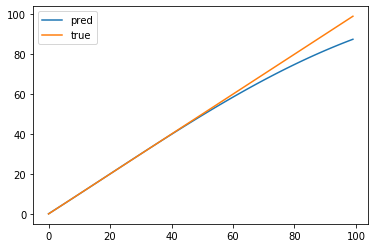

In [381]:
for _ in range(50):
    num_test_processes = 1
    gp_list, _, _ = get_sin_task_sequence(1, 1, num_test_processes, 0.1)

    x_train = np.arange(40)
    y_train = np.arange(40)
    gp_list[0][0].fit(np.atleast_2d(x_train).T, np.atleast_2d(y_train).T)

    x_points = np.atleast_2d(np.arange(100)).T
    pred, sigma = gp_list[0][0].predict(x_points, return_std=True)

plt.plot(x_points, pred, label="pred")
plt.plot(x_points, np.arange(100), label="true")
plt.legend()

In [190]:
for _ in range(10):
    num_test_processes = 1
    gp_list, _, _ = get_sin_task_sequence(1, 1, num_test_processes, 0.1)

    x_train = np.arange(40)
    y_train = np.arange(40)
    gp_list[0][0].fit(np.atleast_2d(x_train).T, np.atleast_2d(y_train).T)

    x_points = np.atleast_2d(np.arange(100)).T
    pred, sigma = gp_list[0][0].predict(x_points, return_std=True)

plt.plot(x_points, pred, label="pred")
plt.plot(x_points, np.arange(100), label="true")
plt.legend()

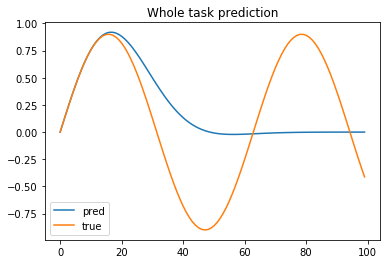

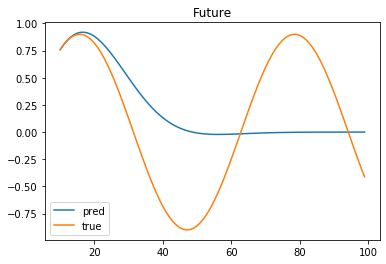

In [475]:
f = 0.1
a = 0.9
offset = 0. 
num_train_x = 10
num_horizon = 100

gp_list, _, _ = get_sin_task_sequence(0.001, 1, num_test_processes, 0.1)

x_train = np.arange(num_train_x)
y_train = a * np.sin(f*x_train)
gp_list[0][0].fit(np.atleast_2d(x_train).T, np.atleast_2d(y_train).T)

x_points = np.atleast_2d(np.arange(num_horizon)).T
pred, sigma = gp_list[0][0].predict(x_points, return_std=True)

plt.plot(x_points, pred, label="pred")
plt.plot(x_points, a*np.sin(f*np.arange(num_horizon)), label="true")
plt.legend()
plt.title("Whole task prediction")
plt.show()

plt.plot(x_points[num_train_x:], pred[num_train_x:], label="pred")
plt.plot(x_points[num_train_x:], a*np.sin(f*np.arange(num_horizon))[num_train_x:], label="true")
plt.legend()
plt.title("Future")
plt.show()

In [474]:
env = gym.make("CarRacing-v0")

AttributeError: module 'gym.envs.box2d' has no attribute 'CarRacing'

In [126]:
import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import gym_sin
from gym import spaces

from utilities.arguments import get_args
from learner.posterior_multi_task import PosteriorMTAgent
from inference.inference_network import InferenceNetwork
from task.ExploitTaskGenerator import ExploitTaskGenerator
from utilities.folder_management import handle_folder_creation


In [127]:
env_name = "exploit-v0"
action_space = spaces.Discrete(3)
latent_dim = 1
theta_min = -0.1
theta_max = 0.1
noise_var = 0.01

device = "cpu"
task_generator = ExploitTaskGenerator(noise_var=noise_var, theta_min=theta_min, theta_max=theta_max)
f = task_generator.create_task_family(n_tasks=5000, n_batches=1, test_perc=0, batch_size=1)

In [139]:
task_generator.sample_pair_tasks(1)

([{'noise_var': 0.01, 'theta': -0.10000000149011612}], None, [tensor([[0.0000],
          [0.1000]])], tensor([[-0.1000]]))

In [218]:
logvar_hat = (torch.ones(32, 1) * 0.4).log()
logvar_prior = (torch.ones(32, 1) * 20).log() 

mu_hat = torch.rand(32, 1)
mu_prior = mu_hat - 0.1

In [219]:
(torch.log(torch.prod(logvar_prior.exp(), 1) / torch.prod(logvar_hat.exp(), 1)))

tensor([3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120,
        3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120,
        3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120,
        3.9120, 3.9120, 3.9120, 3.9120, 3.9120])

In [220]:
(torch.sum(
        -1 + (mu_hat - mu_prior).pow(2) * (1 / logvar_prior.exp()) + (logvar_hat.exp() * (1 / logvar_prior.exp())), 1))


tensor([-0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795,
        -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795,
        -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795,
        -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795])

In [233]:
c = 0
for _ in range(5000):
    r = torch.normal(torch.tensor([50.]), torch.tensor([20.])).item()
    if r < 0:
        c += 1
c

39

In [240]:
for i in range(10):
    if i < 10 - 1:
        print(i)
        

0
1
2
3
4
5
6
7
8


In [241]:
for i in range(10):
    print(i)
        

0
1
2
3
4
5
6
7
8
9


In [242]:
for iter in range(20):
    print(iter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [244]:
envs

NameError: name 'envs' is not defined

In [268]:
min_friction = 0.065
max_friction = 0.196
prior_std_min = 0.001
prior_std_max = 0.05

num_processes = 4

In [280]:
ok = True
while ok:
    mu = (min_friction - max_friction) * torch.rand(num_processes) + max_friction
    std = (prior_std_min - prior_std_max) * torch.rand(num_processes) + prior_std_max

    new_tasks = torch.normal(mu, std).reshape(num_processes, 1)

    if torch.sum(new_tasks > max_friction) + torch.sum(new_tasks < min_friction) == 0:
        ok = False

prior = [torch.tensor([[mu[i]],[std[i]]]) for i in range(num_processes)]

In [297]:
prior[3]

tensor([[0.1735],
        [0.0039]])

In [298]:
c = torch.zeros(32, 14, 5)
obs = torch.ones((32, 3))

In [302]:
c[:, 0, 2:] = obs

In [304]:
c[:, 0]

tensor([[0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]])

In [ ]:
import torch
import torch.nn.functional as F


class InferenceNetworkNew(torch.nn.Module):
    """
    Input:
        Previous latent space
        sequence of data from the current task and old task at that point
        prior over the current task (expressed as vector mu and c)

    Output:
        - sample from the probability distribution over the latent space
        - mu and logvar from the posterior distribution
    """

    def __init__(self, n_in, z_dim):
        super(InferenceNetwork, self).__init__()
        self.z_dim = z_dim
        self.n_in = n_in

        self.enc2 = torch.nn.GRU(input_size=n_in, hidden_size=32, num_layers=1, batch_first=True)
        self.enc3 = torch.nn.Linear(32 + z_dim * 2 + 1, 16)  # hidden + the prior + seq_len
        self.enc41 = torch.nn.Linear(16, z_dim)
        self.enc42 = torch.nn.Linear(16, z_dim)

        self.h = None
        self.seq_len = 0

    def encode(self, context, prior, use_prev_state):
        # Compute batch number and lenght of the sequence
        n_batch = context.shape[0]
        seq_len = context.shape[1]

        # Data preparation
        original_prior = prior
        if len(original_prior.shape) == 1:
            original_prior = original_prior.unsqueeze(0)
        prior = prior.reshape(n_batch, 1, 2)
        prior = prior.repeat(1, seq_len, 1)

        context = torch.cat([context, prior], dim=2).view(n_batch, seq_len, self.n_in)

        # Data processing
        if use_prev_state and self.h is not None:
            t, self.h = self.enc2(context, self.h)
        else:
            t, self.h = self.enc2(context)
        t = t[:, -1, :]  # we are interested only in the last output of the sequence
        t = F.elu(t)

        self.seq_len += seq_len
        trust = torch.tensor([self.seq_len], dtype=t.dtype).repeat(n_batch, 1)
        t = torch.cat([t, original_prior, trust], 1)
        t = F.elu(self.enc3(t))

        # Return encoded mu and logvar
        return self.enc41(t), self.enc42(t)

    def reparameterize(self, mu, logvar):
        # Re-parametrization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, context, prior, use_prev_state):
        if not use_prev_state:
            self.h = None
            self.seq_len = 0

        mu, logvar = self.encode(context, prior, use_prev_state)
        z = self.reparameterize(mu=mu, logvar=logvar)
        return z, mu, logvar


In [316]:
prev_state = torch.ones((16, 1), dtype=torch.bool)
for i in range(16):
    prev_state[i, 0] = np.random.binomial(n=1, p=0.5)

In [317]:
hn = torch.rand(1, 16, 32)

In [323]:
hn[0, prev_state.squeeze(1), :] = 0

In [326]:
hn[0,0,:]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [330]:
torch.logical_not(prev_state)

tensor([[False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True]])

array([-0.03587684, -0.03410754,  0.01189814,  0.00200269])

In [343]:
import gym
env = gym.make("CartPole-v0")
env.reset()
for i in range(150):
    a, r, d, _ = env.step(1)
    if d == True:
        env.reset()
        print(i)
        print(a)

8
[ 0.16927955  1.77576953 -0.24055599 -2.80429097]
16
[ 0.06704088  1.54581166 -0.21277598 -2.56989173]
25
[ 0.15901013  1.74361873 -0.22855912 -2.79840056]
35
[ 0.19894737  1.94736322 -0.21946133 -2.97884809]
44
[ 0.09704584  1.76173197 -0.24635658 -2.86659514]
54
[ 0.14127871  1.998918   -0.2146721  -2.9805171 ]
63
[ 0.14988865  1.77636818 -0.22454883 -2.80868439]
73
[ 0.20888934  1.9390127  -0.21817536 -2.99627614]
82
[ 0.17824009  1.73757791 -0.2232052  -2.81098757]
92
[ 0.15609591  1.97811273 -0.22621691 -3.01417999]
101
[ 0.10704379  1.77330509 -0.25256855 -2.85539394]
110
[ 0.14873064  1.72538509 -0.25905524 -2.89337132]
119
[ 0.10381458  1.74486331 -0.2273765  -2.77223515]
129
[ 0.15396771  1.94965583 -0.23940368 -3.04990413]
138
[ 0.10628405  1.73487182 -0.24729505 -2.84932096]
148
[ 0.19655252  1.93603939 -0.25165039 -3.05892511]


In [344]:
np.random.rand()

0.8377280415990496

In [345]:
layer = torch.nn.GRU(input_size=3, hidden_size=32, num_layers=1, batch_first=True)

In [347]:
t = torch.rand(15, 10, 3)

In [375]:
#ended = torch.zeros(32, dtype=torch.bool)
done = torch.zeros((32, 1), dtype=torch.bool)
done[3] = True
done[6] = True
done[10] = True
done[15] = True

In [368]:
ended = (~torch.eq(ended, done.squeeze(1))) & (~torch.eq(ended, done.squeeze(1)))
ended

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [376]:
ended = ended | done.squeeze(1)

In [377]:
ended

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

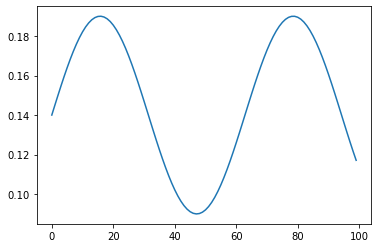

In [423]:
x = np.arange(100)
min_friction = 0.065
max_friction = 0.196

f = 0.1
a = 0.0655
offset = 0.14
a=0.05
y = a * np.sin(f * x) + offset

plt.plot(x, y)

In [424]:
y.max()

0.18997868015207528

0.0655

In [425]:
25000/250

100.0

In [426]:
12500/250

50.0

In [427]:
12500/125

100.0

(array([ 1.,  0.,  0.,  6.,  7., 11., 14.,  5.,  4.,  2.]),
 array([-0.99171233, -0.83254737, -0.67338241, -0.51421746, -0.3550525 ,
        -0.19588754, -0.03672259,  0.12244237,  0.28160733,  0.44077229,
         0.59993724]),
 <a list of 10 Patch objects>)

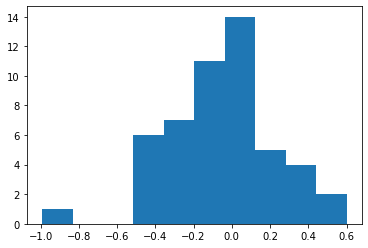

In [442]:
t = np.random.normal(0, 0.3, size=50)
plt.hist(t)

In [469]:
(0.196 - 0.065) / (1 - (-1)) * (1 - 1) + 0.196

0.196

In [465]:
def _rescale_action(action, max_new, min_new):
    if max_new is not None or min_new is not None:
        return (max_new - min_new) / (1 - (-1)) * (action - 1) + max_new
    else:
        return action

In [466]:
_rescale_action(1, 0.196, 0.065)

0.196

In [476]:
from gym import spaces

In [481]:

high_act = np.array([
    1,
    np.pi,
], dtype=np.float32)

low_act = np.array([
    0,
    -np.pi
], dtype=np.float32)

action_space = spaces.Box(low=low_act, high=high_act)

In [479]:
action_space

Box(2,)

In [484]:
size = 10
state_x = np.random.uniform(low=-size, high=size, size=1)[0]
state_y = np.random.uniform(low=-size, high=size, size=1)[0]
direction = np.random.uniform(low=0, high=np.pi, size=1)[0]
(state_x, state_y, direction)

(0.08983764436808706, -1.282557881132746, 0.8915582422171423)

In [3]:
import numpy as np

In [2]:
action = (1, 5)

In [4]:
np.sqrt(0.05)

0.22360679774997896

In [5]:
import torch

In [13]:
min_v = torch.zeros(5)
max_v = torch.ones(5)

sample = torch.rand(3, 5)

In [14]:
sample

tensor([[0.8644, 0.3661, 0.4337, 0.7655, 0.0068],
        [0.9592, 0.3910, 0.7011, 0.2496, 0.7226],
        [0.4816, 0.9849, 0.3614, 0.4741, 0.8491]])

In [15]:
(min_v - max_v) * sample + max_v

tensor([[0.1356, 0.6339, 0.5663, 0.2345, 0.9932],
        [0.0408, 0.6090, 0.2989, 0.7504, 0.2774],
        [0.5184, 0.0151, 0.6386, 0.5259, 0.1509]])

In [254]:
import torch

from task.task_generator import TaskGenerator


class GridWorldTaskGenerator(TaskGenerator):

    def __init__(self, size, goal_radius, charge_forward_min, charge_forward_max,
                 charge_rotation_min, charge_rotation_max, prior_goal_std_min,
                 prior_goal_std_max, prior_charge_std_min, prior_charge_std_max):
        super(GridWorldTaskGenerator, self).__init__()

        self.latent_dim = 5

        # Fixed env setting
        self.size = size
        self.goal_radius = goal_radius

        # Env latent space
        goal_max = size / 2
        goal_min = -size / 2

        self.latent_min_mean = torch.tensor([goal_min, goal_min, charge_forward_min,
                                             charge_rotation_min, charge_rotation_min], dtype=torch.float32)
        self.latent_max_mean = torch.tensor([goal_max, goal_max, charge_forward_max,
                                             charge_rotation_max, charge_rotation_max], dtype=torch.float32)
        self.latent_min_std = torch.tensor([prior_goal_std_min, prior_goal_std_min, prior_charge_std_min,
                                            prior_charge_std_min, prior_charge_std_max], dtype=torch.float32)
        self.latent_max_std = torch.tensor([prior_goal_std_max, prior_goal_std_max, prior_charge_std_max,
                                            prior_charge_std_max, prior_charge_std_max], dtype=torch.float32)

    def create_task_family(self, n_tasks, n_batches=1, test_perc=0, batch_size=160):
        raise NotImplemented

    def sample_task_from_prior(self, prior):
        ok = True
        while ok:
            mu = prior[0].clone().detach()
            var = prior[1].clone().detach()

            task_param = torch.normal(mu, var)

            if torch.sum(task_param > self.latent_max_mean) + torch.sum(task_param < self.latent_min_mean) == 0:
                ok = False

        envs_kwargs = {'size': self.size,
                       'goal_x': task_param[0].item(),
                       'goal_y': task_param[1].item(),
                       'goal_radius': self.goal_radius,
                       'charge_forward': task_param[2].item(),
                       'charge_left': task_param[3].item(),
                       'charge_right': task_param[4].item()}

        return envs_kwargs

    def sample_pair_tasks(self, num_p):
        mu = (self.latent_min_mean - self.latent_max_mean) * torch.rand(num_p, self.latent_dim) + self.latent_max_mean
        std = (self.latent_min_std - self.latent_max_std) * torch.rand(num_p, self.latent_dim) + self.latent_max_std
        new_tasks = torch.normal(mu, std).reshape(num_p, self.latent_dim)
        not_ok_task = torch.any(new_tasks > self.latent_max_mean, 1) | torch.any(new_tasks < self.latent_min_mean, 1)

        while torch.sum(not_ok_task) != 0:
            temp_new_tasks = torch.normal(mu, std).reshape(num_p, self.latent_dim)

            new_tasks[not_ok_task, :] = temp_new_tasks[not_ok_task]
            not_ok_task = (
                        torch.any(new_tasks > self.latent_max_mean, 1) | torch.any(new_tasks < self.latent_min_mean, 1))

        prior = [torch.tensor([mu[i].tolist(), std[i].tolist()]) for i in range(1)]

        envs_kwargs = [{'size': self.size,
                        'goal_x': new_tasks[i][0].item(),
                        'goal_y': new_tasks[i][1].item(),
                        'goal_radius': self.goal_radius,
                        'charge_forward': new_tasks[i][2].item(),
                        'charge_left': new_tasks[i][3].item(),
                        'charge_right': new_tasks[i][4].item()}
                       for i in range(num_p)]

        return envs_kwargs, None, prior, new_tasks


In [255]:
task_gen = GridWorldTaskGenerator(size=8,
                                      goal_radius=0.2, 
                                      charge_forward_min=0.5, 
                                      charge_forward_max=1,
                                      charge_rotation_min=0.2, 
                                      charge_rotation_max=1, 
                                      prior_goal_std_min=0.1,
                                      prior_goal_std_max=2,
                                      prior_charge_std_min=0.01,
                                      prior_charge_std_max=0.1)

In [256]:
p = task_gen.sample_pair_tasks(1)[2]

In [257]:
task_gen.sample_task_from_prior(p[0])

{'size': 8,
 'goal_x': 0.39852774143218994,
 'goal_y': -1.3080995082855225,
 'goal_radius': 0.2,
 'charge_forward': 0.8743904232978821,
 'charge_left': 0.48559799790382385,
 'charge_right': 0.4825255572795868}

In [1]:
import gym
import gym_sin
import numpy as np

In [25]:
env = gym.make("navigation-v0", goal_theta=-1, signals_dim=0, mean_x_vec=np.array([]), mean_y_vec=np.array([]))

In [26]:
env.reset()

array([[0, 0]])

In [39]:
env.step([1, -1])

(array([[0.90364917, 0.        ]]), 10, True, {})

In [14]:
env.x_balance_lvl

0.0

In [15]:
np.array([env.state])[0,0]

1.042801200900255

# Check policy

In [1]:
import numpy as np
from gym import spaces
import torch
import os
from learner.ours import OursAgent
from task.gridworld_task_generator import GridWorldTaskGenerator
import gym_sin
import matplotlib.pyplot as plt

size = 8
goal_radius = 0.5
prior_goal_std_min = 0.001
prior_goal_std_max = 0.1
prior_charge_std_min = 0.001
prior_charge_std_max = 0.1
latent_dim = 5

task_generator = GridWorldTaskGenerator(size=size,
                                            goal_radius=goal_radius,
                                            prior_goal_std_min=prior_goal_std_min,
                                            prior_goal_std_max=prior_goal_std_max,
                                            prior_charge_std_min=prior_charge_std_min,
                                            prior_charge_std_max=prior_charge_std_max)

In [2]:
f = "../result/gridwolrdv0/temp/"
env_name="gridworld-v0"
seed = 0
log_dir = "."
use_env_obs = True

high_act = np.array([
        1,
        np.pi / 2,
    ], dtype=np.float32)

low_act = np.array([
        0,
        -np.pi / 2
    ], dtype=np.float32)

action_space = spaces.Box(low=low_act, high=high_act)

res_list = []

model_list = []
vi_list = []
dirs_containing_res = os.listdir(f)

for d in dirs_containing_res:
    model_list.append(torch.load(f + d + "/agent_ac"))
    vi_list.append(torch.load(f + d + "/agent_vi"))

for model, vi in zip(model_list, vi_list):
    agent = OursAgent(action_space=action_space, device="cpu", gamma=0.99,
                          num_steps=30, num_processes=32,
                          clip_param=0.2, ppo_epoch=4,
                          num_mini_batch=8,
                          value_loss_coef=0.5,
                          entropy_coef=0,
                          lr=0.00005,
                          eps=1e-6, max_grad_norm=0.5,
                          use_linear_lr_decay=False,
                          use_gae=False,
                          gae_lambda=0.95,
                          use_proper_time_limits=False,
                          obs_shape=(13, ),
                          latent_dim=5,
                          recurrent_policy=False,
                          hidden_size=16,
                          use_elu=True,
                          variational_model=None,
                          vae_optim=None,
                          rescale_obs=False,
                          max_old=None,
                          min_old=None,
                          vae_min_seq=1,
                          vae_max_seq=30,
                          max_action=None,
                          min_action=None,
                          max_sigma=None,
                          use_decay_kld=True,
                          decay_kld_rate=1,
                          env_dim=3,
                          action_dim=2
                          )

    agent.actor_critic = model
    agent.vae = vi
    
    agent.evaluate_debug(512, task_generator,".", 0,True,'gridworld-v0')

Evaluation...
Evaluation using 512 tasks. Mean reward: -24.832283673828126


In [3]:
_, infos, bad_goals  =agent.evaluate_debug(2048, task_generator,".", 0,True,'gridworld-v0')

Evaluation...
Evaluation using 2048 tasks. Mean reward: -24.156289963378907


In [4]:
l_list = [elem['l'] for elem in infos]
r_list = [elem['r'] for elem in infos]

(array([347., 568., 395., 236.,  63.,  78.,  34.,  39.,  28., 260.]),
 array([ 2. ,  4.8,  7.6, 10.4, 13.2, 16. , 18.8, 21.6, 24.4, 27.2, 30. ]),
 <a list of 10 Patch objects>)

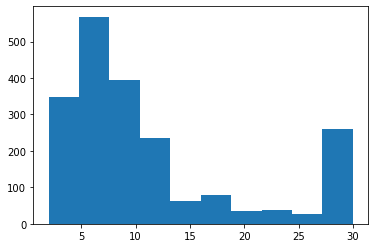

In [5]:
t = np.array(l_list)
plt.hist(t)

(array([  1.,   1.,   5.,  10.,  42., 135., 323., 345., 564., 622.]),
 array([-118.383726 , -106.6415541,  -94.8993822,  -83.1572103,
         -71.4150384,  -59.6728665,  -47.9306946,  -36.1885227,
         -24.4463508,  -12.7041789,   -0.962007 ]),
 <a list of 10 Patch objects>)

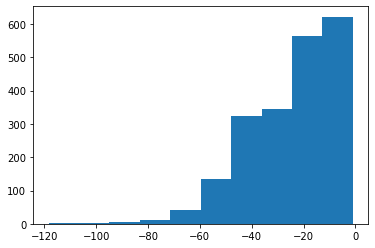

In [6]:
t = np.array(r_list)
plt.hist(t)

In [7]:
joint = np.array([r_list, l_list])

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,   2.],
        [  0.,   0.,   0.,   0.,   3.,   2.,   0.,   1.,   0.,   4.],
        [  0.,   0.,   0.,   8.,   9.,   0.,   4.,   1.,   2.,  18.],
        [  0.,   0.,   0.,  59.,   2.,   9.,   7.,   2.,   8.,  48.],
        [  0.,   0.,  44.,  62.,   7.,  22.,   1.,  16.,  10., 161.],
        [  0.,   0., 193.,  28.,  21.,  34.,  19.,  17.,   8.,  25.],
        [  0., 312., 139.,  79.,  21.,  10.,   3.,   0.,   0.,   0.],
        [347., 256.,  19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([-118.383726 , -106.6415541,  -94.8993822,  -83.1572103,
         -71.4150384,  -59.6728665,  -47.9306946,  -36.1885227,
         -24.4463508,  -12.7041789,   -0.962007 ]),
 array([ 2. ,  4.8,  7.6, 10.4, 13.2, 16. , 18.8, 21.6, 24.4, 27.2, 30. ]),
 <matplotlib.collections.QuadMesh at 0x21c

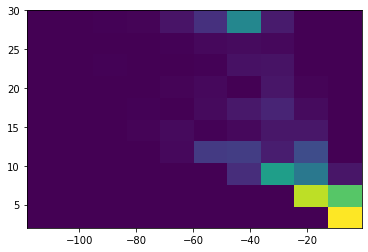

In [8]:
plt.hist2d(joint[0], joint[1]) 

In [11]:
x_list = [elem['goal_x'] for elem in bad_goals]
y_list = [elem['goal_y'] for elem in bad_goals]

(array([30., 25., 19., 17., 21., 31., 23., 32., 24., 28.]),
 array([-0.90633309, -0.72945936, -0.55258563, -0.37571189, -0.19883816,
        -0.02196443,  0.1549093 ,  0.33178303,  0.50865676,  0.6855305 ,
         0.86240423]),
 <a list of 10 Patch objects>)

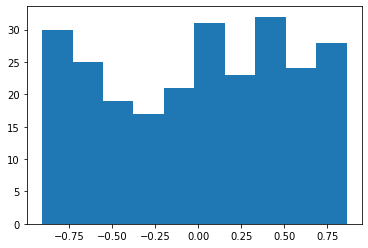

In [13]:
plt.hist(x_list)

(array([22., 28., 18., 24., 28., 22., 18., 30., 31., 29.]),
 array([-0.87750477, -0.70116133, -0.5248179 , -0.34847446, -0.17213103,
         0.00421241,  0.18055584,  0.35689928,  0.53324271,  0.70958615,
         0.88592958]),
 <a list of 10 Patch objects>)

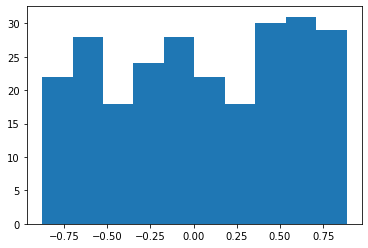

In [14]:
plt.hist(y_list)

(array([[3., 2., 3., 4., 2., 4., 1., 4., 2., 5.],
        [2., 1., 5., 0., 5., 1., 2., 3., 5., 1.],
        [2., 1., 2., 2., 3., 2., 2., 2., 0., 3.],
        [0., 3., 1., 4., 0., 1., 2., 3., 1., 2.],
        [2., 4., 1., 2., 1., 3., 2., 4., 2., 0.],
        [1., 5., 1., 2., 7., 2., 2., 2., 5., 4.],
        [4., 2., 0., 3., 3., 3., 1., 2., 1., 4.],
        [1., 5., 3., 1., 5., 3., 3., 6., 2., 3.],
        [1., 2., 1., 2., 0., 0., 1., 3., 9., 5.],
        [6., 3., 1., 4., 2., 3., 2., 1., 4., 2.]]),
 array([-0.90633309, -0.72945936, -0.55258563, -0.37571189, -0.19883816,
        -0.02196443,  0.1549093 ,  0.33178303,  0.50865676,  0.6855305 ,
         0.86240423]),
 array([-0.87750477, -0.70116133, -0.5248179 , -0.34847446, -0.17213103,
         0.00421241,  0.18055584,  0.35689928,  0.53324271,  0.70958615,
         0.88592958]),
 <matplotlib.collections.QuadMesh at 0x21cda8a1588>)

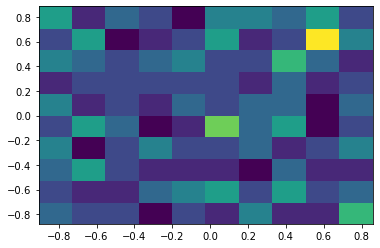

In [15]:
plt.hist2d(x_list, y_list)

In [20]:
joint[1].mean()

11.33837890625

In [21]:
joint[0].mean()

-24.156289963378907

In [2]:
import numpy as np

In [64]:
cov = np.array([[0.5,0], [0, 0.5]])
mean = np.array([[0, 0]])
x = np.array([2,2])
np.exp(-0.5 * np.dot(np.dot(mean - x, np.linalg.inv(cov)), (mean - x).transpose()))

array([[0.00033546]])

In [54]:
np.power(np.linalg.det(2 * np.pi * sigma), -0.5) * 

array([[0.15915494]])

In [55]:
np.exp(-0.5 * np.dot(np.dot(mean - x, np.linalg.inv(cov)), (mean - x).transpose()))

array([[1.]])

In [53]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
var.pdf([0,0])

0.15915494309189535

In [67]:
np.diag([1,1])

array([[1, 0],
       [0, 1]])

In [14]:
cov = np.eye(2)

In [15]:
m1.shape

(3, 1)

In [16]:
m1 = np.expand_dims(np.array([1,2,3]), 1)
m2 = np.expand_dims(np.array([1,2,3]), 1)
m = np.concatenate([m1, m2], 1)

In [17]:
s = np.array([3,3])

In [18]:
np.exp(-0.5 * np.dot(np.dot(m-s, np.linalg.inv(cov)), (m-s).transpose()).diagonal())

array([0.01831564, 0.36787944, 1.        ])

In [135]:
(1,2)+(4,5,6)

(1, 2, 4, 5, 6)

In [136]:
t = np.array([11,22,33,44,55])

In [138]:
t[2:]

array([33, 44, 55])

In [21]:
import torch

In [23]:
t = torch.tensor([4])

In [24]:
t.repeat(4)

tensor([4, 4, 4, 4])

In [34]:
t = torch.arange(10) 

In [35]:
t

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [37]:
signals_dim=2
t[2:4].numpy()

array([2, 3], dtype=int64)

In [50]:
import torch

In [51]:
signals_dim = 2

prior_goal_std_min = 0.00001
prior_goal_std_max = 0.2
prior_balance_std_min = 0.00001
prior_balance_std_max = 0.2
prior_signal_std_min = 0.0001
prior_signal_std_max = 0.5


latent_min_std = torch.tensor([prior_goal_std_min, prior_goal_std_min,
                                            prior_balance_std_min, prior_balance_std_min], dtype=torch.float32)
latent_min_std = torch.cat(
    [latent_min_std, torch.tensor([prior_signal_std_min]).repeat(2 * signals_dim)])

latent_max_std = torch.tensor([prior_goal_std_max, prior_goal_std_max,
                                    prior_balance_std_max, prior_balance_std_max], dtype=torch.float32)
latent_max_std = torch.cat(
    [latent_max_std, torch.tensor([prior_signal_std_max]).repeat(2 * signals_dim)])


In [53]:
size = 10
goal_radius = 0.5

In [55]:
from task.gridworld_task_generator import GridWorldTaskGenerator
task_generator = GridWorldTaskGenerator(size=size,
                                            goal_radius=goal_radius,
                                            prior_goal_std_min=prior_goal_std_min,
                                            prior_goal_std_max=prior_goal_std_max,
                                            prior_balance_std_min=prior_balance_std_min,
                                            prior_balance_std_max=prior_balance_std_max,
                                            signals_dim=signals_dim,
                                            prior_signal_std_min=prior_signal_std_min,
                                            prior_signal_std_max=prior_signal_std_max)

In [59]:
task_generator.sample_pair_tasks(1)

([{'size': 10,
   'goal_x': -0.6364010572433472,
   'goal_y': -0.6827036142349243,
   'goal_radius': 0.5,
   'x_balance_lvl': 0.04351254552602768,
   'y_balance_lvl': 0.5418527126312256,
   'mean_x_vec': array([-0.5786819 ,  0.07139079], dtype=float32),
   'mean_y_vec': array([-0.994364 , -0.2786163], dtype=float32),
   'signals_dim': 2}],
 None,
 [tensor([[-0.6949, -0.9201,  0.0573,  0.5093, -0.6927,  0.2611, -0.9758, -0.8102],
          [ 0.1743,  0.1297,  0.0140,  0.1220,  0.1379,  0.4484,  0.0277,  0.3019]])],
 tensor([[-0.6364, -0.6827,  0.0435,  0.5419, -0.5787,  0.0714, -0.9944, -0.2786]]))

In [63]:
for _ in range(100):
    t = (-1 - 1) * torch.rand(1) + 1
    print(t)

tensor([-0.2869])
tensor([-0.0708])
tensor([0.8184])
tensor([0.6415])
tensor([0.6315])
tensor([0.2777])
tensor([-0.1405])
tensor([-0.1458])
tensor([-0.4533])
tensor([-0.0048])
tensor([-0.1887])
tensor([0.8353])
tensor([-0.4639])
tensor([-0.6934])
tensor([-0.9700])
tensor([0.0010])
tensor([-0.3788])
tensor([0.2903])
tensor([0.7979])
tensor([-0.0114])
tensor([0.0120])
tensor([0.0991])
tensor([-0.4967])
tensor([0.2318])
tensor([-0.2951])
tensor([-0.0973])
tensor([-0.4276])
tensor([0.2559])
tensor([0.3691])
tensor([-0.1065])
tensor([0.7708])
tensor([0.7182])
tensor([0.1141])
tensor([-0.0304])
tensor([-0.2667])
tensor([0.5156])
tensor([-0.7460])
tensor([0.7554])
tensor([0.3266])
tensor([0.8536])
tensor([0.4102])
tensor([0.8829])
tensor([0.8357])
tensor([0.4531])
tensor([-0.9757])
tensor([-0.5309])
tensor([0.7497])
tensor([-0.5989])
tensor([0.9455])
tensor([-0.9520])
tensor([0.8857])
tensor([0.8343])
tensor([-0.1366])
tensor([0.8302])
tensor([-0.9544])
tensor([-0.1393])
tensor([-0.7927])
ten

In [64]:
t = np.array([1,2,3,4,5])

In [65]:
assert np.all(0 <= t <= 10), "Fail"

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [67]:
assert np.all(100>t>10)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [74]:
size = 10
theta = np.pi / 4
x = size * np.cos(theta)
y = size * np.sin(theta)

print("X {} Y {}".format(x, y))

X 7.0710678118654755 Y 7.0710678118654755


In [45]:
import torch
t = torch.arange(10, dtype=torch.float32)
t

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [46]:
t[2:3]

tensor([2.])

In [47]:
t[0] = float('nan')

In [48]:
t

tensor([nan, 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [51]:
torch.isnan(t).any()

tensor(True)

In [54]:
t[0].item() == float('nan')

False

In [58]:
t[0].item() == t[0].item()

False

In [59]:
t[1].item() == t[1].item()

True

In [60]:
0 / 0

ZeroDivisionError: division by zero

In [61]:
torch.isinf(t)

tensor([False, False, False, False, False, False, False, False, False, False])

In [62]:
t.abs()

tensor([nan, 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [87]:
l = torch.nn.GRU(input_size=15,hidden_size=10, num_layers=1)

In [90]:
from inference.inference_network import InferenceNetwork
inference_net = InferenceNetwork(10, 4)

In [107]:
for p in inference_net.named_parameters():
    print(p[1].max())

tensor(0.1766, grad_fn=<MaxBackward1>)
tensor(0.1767, grad_fn=<MaxBackward1>)
tensor(0.1716, grad_fn=<MaxBackward1>)
tensor(0.1760, grad_fn=<MaxBackward1>)
tensor(0.1559, grad_fn=<MaxBackward1>)
tensor(0.1451, grad_fn=<MaxBackward1>)
tensor(0.2459, grad_fn=<MaxBackward1>)
tensor(0.2292, grad_fn=<MaxBackward1>)
tensor(0.2158, grad_fn=<MaxBackward1>)
tensor(0.2327, grad_fn=<MaxBackward1>)


In [99]:
p.name

In [111]:
o = torch.optim.Adam(inference_net.parameters())

In [117]:
for param_group in o.param_groups:
    print(param_group['lr'])

0.001


In [239]:
import torch
import torch.nn.functional as F
def temp(z, mu_hat, logvar_hat, mu_prior, logvar_prior,
                               n_samples, use_decay, decay_param, epoch, verbose):
    mse_direct = F.mse_loss(mu_hat, z)
    mse_var = torch.mean(torch.sum(logvar_hat.exp(), 1))
    mse = mse_direct + mse_var

    kdl_1 = torch.sum(torch.log(logvar_prior.exp()) - torch.log(v.exp()), 1)
    kld_2 = (torch.sum(
        -1 + (mu_hat - mu_prior).pow(2) * (1 / logvar_prior.exp()) + (logvar_hat.exp() * (1 / logvar_prior.exp())), 1))
    kld = (1 / 2) * torch.mean(kdl_1)
    
    if use_decay:
        kld = kld * (decay_param / n_samples)

    if verbose and epoch is not None and epoch % 100 == 0:
        print("Epoch {} MSE DIR {} MSE VAR {} KLD {} STEPS {}".format(epoch, mse_direct.item(), mse_var.item(),
                                                                      kld.item(), n_samples))
        print("X {} Y {} ".format(z[1][0], z[1][1]))
        print("HX {} HY {}".format(mu_hat[1][0], mu_hat[1][1]))
        print("\n")
    return mse + kld, kld.item(), mse.item()

vae = torch.load("nanvae")
optim = torch.load("optim")
new_t = torch.load("newtasks")
ctx = torch.load("nanctx")
mu_prior = torch.load("muprior")
logvar_prior = torch.load("logvar_prior")
prior = torch.load("prior")

with torch.autograd.detect_anomaly():
    optim.zero_grad()
    _, m, v = vae(ctx, prior)
    loss, kdl, mse = temp(z=new_t,
                        mu_hat=m,
                        logvar_hat=v,
                        mu_prior=mu_prior,
                        logvar_prior=logvar_prior,
                        n_samples=138,
                        use_decay=True,
                        decay_param=1,
                        epoch=0,
                        verbose=False
                        )
    loss.backward()

In [215]:
(torch.prod(v.exp(), 1))

tensor([2.2486e-23, 3.3589e-23, 6.2611e-23, 3.0600e-23, 3.3403e-23, 2.6000e-23,
        2.6007e-23, 5.5396e-23, 6.9912e-23, 2.8878e-23, 4.7563e-23, 2.8266e-23,
        5.2915e-23, 3.6340e-23, 6.6136e-23, 4.4179e-23],
       grad_fn=<ProdBackward1>)

In [216]:
v

tensor([[-7.1276, -5.8649, -5.4963, -8.8936, -6.8340, -5.9661, -6.4017, -5.5649],
        [-7.1050, -5.8293, -5.5046, -8.8330, -6.7072, -5.9352, -6.4000, -5.4335],
        [-7.0200, -5.7106, -5.3935, -8.7965, -6.5734, -5.8689, -6.4052, -5.3569],
        [-7.0878, -5.8335, -5.5103, -8.8543, -6.7462, -5.9725, -6.3914, -5.4451],
        [-7.0880, -5.7929, -5.4945, -8.8540, -6.7481, -5.9343, -6.3693, -5.4722],
        [-7.1561, -5.8187, -5.4999, -8.8546, -6.8089, -5.9680, -6.4175, -5.4802],
        [-7.0982, -5.8922, -5.5485, -8.8609, -6.7201, -5.9985, -6.4344, -5.4509],
        [-6.9944, -5.7912, -5.4792, -8.7699, -6.6096, -5.8923, -6.3127, -5.3982],
        [-7.0128, -5.7085, -5.4569, -8.7160, -6.5849, -5.8700, -6.3304, -5.3352],
        [-6.9526, -5.8977, -5.4963, -8.8196, -6.7855, -6.0742, -6.3430, -5.5300],
        [-7.0187, -5.7413, -5.4241, -8.7658, -6.6592, -5.9525, -6.3982, -5.4401],
        [-7.0521, -5.8194, -5.4872, -8.8548, -6.7774, -6.0040, -6.3899, -5.5356],
        [-6.9981

In [227]:
torch.log(torch.prod(logvar_prior.exp(), 1) / (1e-10+torch.prod(v.exp(), 1)))

tensor([ 3.5572,  3.4936, -3.9741,  5.3638,  0.5195,  3.3203,  2.4379,  3.8837,
         2.8604,  5.6160,  1.3428,  0.0861,  6.3079,  3.5100, -1.0913,  5.6975],
       grad_fn=<LogBackward>)

In [222]:
(torch.log(torch.prod(logvar_prior.exp(), 1) / (torch.prod(v.exp(), 1))))

tensor([32.6805, 32.2156, 24.1252, 34.1790, 29.2470, 32.2984, 31.4158, 32.1054,
        30.8493, 34.4891, 29.7170, 28.9806, 34.5754, 32.1533, 26.9531, 34.1455],
       grad_fn=<LogBackward>)

In [231]:
torch.sum(torch.log(x) - torch.log(y)) 

tensor(-2.8053)

In [237]:
torch.log(torch.prod(logvar_prior.exp(), 1) / (torch.prod(v.exp(), 1)))

tensor([32.6805, 32.2156, 24.1252, 34.1790, 29.2470, 32.2984, 31.4158, 32.1054,
        30.8493, 34.4891, 29.7170, 28.9806, 34.5754, 32.1533, 26.9531, 34.1455],
       grad_fn=<LogBackward>)

In [241]:
torch.sum(logvar_prior - v, 1)

tensor([32.6805, 32.2156, 24.1252, 34.1790, 29.2470, 32.2984, 31.4158, 32.1054,
        30.8493, 34.4891, 29.7170, 28.9806, 34.5754, 32.1533, 26.9531, 34.1455],
       grad_fn=<SumBackward1>)

In [243]:
1e6

1000000.0

In [244]:
t

tensor([nan, 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [245]:
t = torch.arange(10, dtype=torch.float32)

In [247]:
t.pow(2)

tensor([ 0.,  1.,  4.,  9., 16., 25., 36., 49., 64., 81.])

In [256]:
1e8 / 200 / 16

31250.0

In [257]:
150 * 15 * 50000

112500000

In [258]:
20 * 15 * 150

45000

In [ ]:
def get_const_task_sequence(alpha, n_restarts, num_test_processes, std=0.00000001):
    kernel = C(1.0, (1e-8, 1e8)) * RBF(1, (1e-8, 1e8))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=False,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    friction = -0.7
    init_prior_test = [torch.tensor([[friction], [std]], dtype=torch.float32)
                       for _ in range(num_test_processes)]
    prior_seq = []
    for idx in range(300):
        prior_seq.append(torch.tensor([[friction], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test

In [270]:
idx = 0

while idx < 50:
    if idx <= 20:
        print(-1 + idx / 10)
    elif idx >= 20 and idx < 30 :
        print(1)
    else:
        print(1 - (idx-30) / 10)
    idx += 1

-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.4
-0.30000000000000004
-0.19999999999999996
-0.09999999999999998
0.0
0.10000000000000009
0.19999999999999996
0.30000000000000004
0.3999999999999999
0.5
0.6000000000000001
0.7
0.8
0.8999999999999999
1.0
1
1
1
1
1
1
1
1
1
1.0
0.9
0.8
0.7
0.6
0.5
0.4
0.30000000000000004
0.19999999999999996
0.09999999999999998
0.0
-0.10000000000000009
-0.19999999999999996
-0.30000000000000004
-0.3999999999999999
-0.5
-0.6000000000000001
-0.7
-0.8
-0.8999999999999999


0.775

In [276]:
50000*150*16 - 1e8

20000000.0